#Import and useful functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import zipfile
import pandas as pd
import numpy as np
import string
from nltk.tokenize.treebank import TreebankWordDetokenizer
import string
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from wordcloud import WordCloud
from numpy.random import random

!pip install emot --upgrade
import emot
emot_obj = emot.core.emot() 


nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
""" Copyright 2017, Dimitrios Effrosynidis, All rights reserved. """
#source for the code in the cell: https://github.com/Deffro/text-preprocessing-techniques#readme
#in the report we have cited the paper from which this repository derives

def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def countMultiExclamationMarks(text):
    """ Replaces repetitions of exlamation marks """
    return len(re.findall(r"(\!)\1+", text))

def countMultiQuestionMarks(text):
    """ Count repetitions of question marks """
    return len(re.findall(r"(\?)\1+", text))

def countMultiStopMarks(text):
    """ Count repetitions of stop marks """
    return len(re.findall(r"(\.)\1+", text))

def countElongated(text):
    """ Input: a text, Output: how many words are elongated """
    regex = re.compile(r"(.)\1{2}")
    return len([word for word in text.split() if regex.search(word)])

def countAllCaps(text):
    """ Input: a text, Output: how many words are all caps """
    return len(re.findall("[A-Z0-9]{3,}", text))

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

### Replace Negations Begin ###

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
      for lemma in syn.lemmas():
        for antonym in lemma.antonyms():
          antonyms.add(antonym.name())
    if len(antonyms) == 1:
      return antonyms.pop()
    else:
      return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
      word = text[i]
      if word == 'not' and i+1 < l:
        ant = replace(text[i+1])
        if ant:
          words.append(ant)
          i += 2
          continue
      words.append(word)
      i += 1
    return words

### Replace Negations End ###

def addNotTag(text):
	""" Finds "not,never,no" and adds the tag NEG_ to all words that follow until the next punctuation """
	transformed = re.sub(r'\b(?:not|never|no)\b[\w\s]+[^\w\s]', 
       lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), 
       text,
       flags=re.IGNORECASE)
	return transformed




In [ ]:
def removeCodes(text):
    """ Removes emoticons from text """
    text = re.sub(r'&([#a-zA-Z0-9]*);',' ',text)
    return text

In [ ]:
def preprocess(df):

  text = np.array([replaceURL(df.iloc[i]) for i in range(0,len(df))])
  text = np.array([removeUnicode(text[i]) for i in range(0,len(text))])
  text = np.array([removeCodes(text[i]) for i in range(0,len(text))])
  text = np.array([replaceAtUser(text[i]) for i in range(0,len(text))])
  text = np.array([removeHashtagInFrontOfWord(text[i]) for i in range(0,len(text))])

#text = np.array([replaceContraction(text[i]) for i in range(0,len(text))])

  text = np.array([replaceMultiExclamationMark(text[i]) for i in range(0,len(text))])
  text = np.array([replaceMultiQuestionMark(text[i]) for i in range(0,len(text))])
  text = np.array([replaceMultiStopMark(text[i]) for i in range(0,len(text))])

  for i,row in enumerate(text):
    dct = emot_obj.emoticons(row)
    if dct["flag"] == True:
      for j,el in enumerate(dct["value"]):
        text[i] = text[i].replace(el,"")
        text[i] = text[i] + dct["mean"][j]

  text = [nltk.word_tokenize(text[i]) for i in range(0,len(text))]
    
  text = np.array([replaceNegations(text[i]) for i in range(0,len(text))])
  text = np.array([TreebankWordDetokenizer().detokenize(text[i]) for i in range(0,len(text))])

#text = np.array([addNotTag(text[i]) for i in range(0,len(text))])

#text = np.array([removeNumbers(text[i]) for i in range(0,len(text))])

  text = np.array([replaceElongated(text[i]) for i in range(0,len(text))])

#text = [nltk.word_tokenize(text[i]) for i in range(0,len(text))]
#for i,row in enumerate(text):
  #for j,el in enumerate(row):
    #text[i][j] = lemmatizer.lemmatize(el)
    #text[i][j] = stemmer.stem(el)

#text = np.array([TreebankWordDetokenizer().detokenize(text[i]) for i in range(0,len(text))])

  return text

In [ ]:
!wget "https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip" -O data.zip

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall()

--2022-01-19 14:09:40--  https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
Resolving dbdmg.polito.it (dbdmg.polito.it)... 130.192.163.163
Connecting to dbdmg.polito.it (dbdmg.polito.it)|130.192.163.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18640208 (18M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  17.78M  15.1MB/s    in 1.2s    

2022-01-19 14:09:41 (15.1 MB/s) - ‘data.zip’ saved [18640208/18640208]



In [ ]:
datadev = pd.read_csv("DSL2122_january_dataset/development.csv",parse_dates=["date"])

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


#Data exploration


In [ ]:
m_ex, pos_ex, m_qu, pos_qu, m_st, pos_st, em, pos_em, caps, pos_caps, elon, pos_elon = 0,0,0,0,0,0,0,0,0,0,0,0
for i in range(0,len(datadev)):
  num = countMultiExclamationMarks(datadev.iloc[i,5])
  if num > 0:
    m_ex += num
    pos_ex += datadev.iloc[i,0]
  
  num = countMultiQuestionMarks(datadev.iloc[i,5])
  if num > 0:
    m_qu += num
    pos_qu += datadev.iloc[i,0]
  
  num = countMultiStopMarks(datadev.iloc[i,5])
  if num > 0:
    m_st += num
    pos_st += datadev.iloc[i,0]

  num = countEmoticons(datadev.iloc[i,5])
  if num > 0:
    em += num
    pos_em += datadev.iloc[i,0]

  num = countAllCaps(datadev.iloc[i,5])
  if num > 0:
    caps += num
    pos_caps += datadev.iloc[i,0]

  num = countElongated(datadev.iloc[i,5])
  if num > 0:
    elon += num
    pos_elon += datadev.iloc[i,0]
  

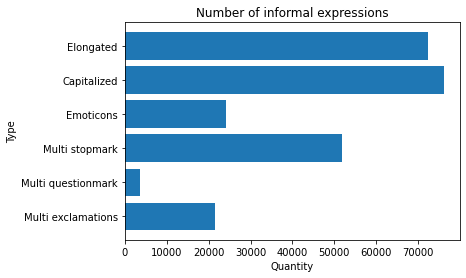

In [ ]:
import matplotlib.pyplot as plt

plt.barh(["Multi exclamations","Multi questionmark","Multi stopmark", "Emoticons", "Capitalized", "Elongated"]
         ,[m_ex,m_qu,m_st,em,caps,elon])
plt.title('Number of informal expressions')
plt.ylabel('Type')
plt.xlabel('Quantity')
fig1 = plt.gcf()
plt.show()
fig1.savefig('filename.svg') 

<BarContainer object of 2 artists>

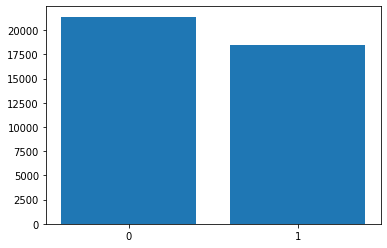

In [ ]:
plt.bar(["0","1"],[sla-pos_sla,pos_sla])

<BarContainer object of 2 artists>

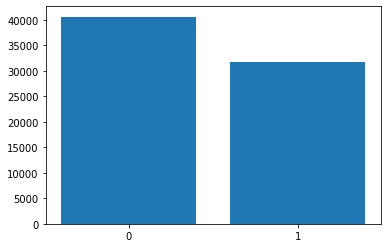

In [ ]:
plt.bar(["0","1"],[elon-pos_elon,pos_elon])

<BarContainer object of 2 artists>

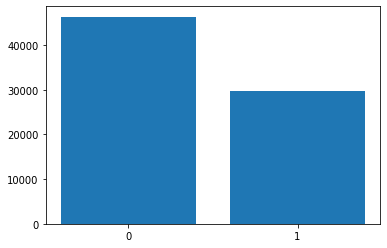

In [ ]:
plt.bar(["0","1"],[caps-pos_caps,pos_caps])

<BarContainer object of 2 artists>

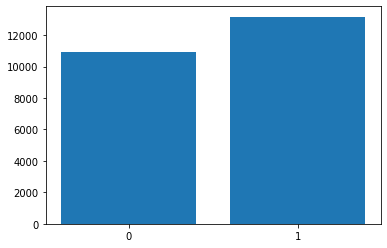

In [ ]:
plt.bar(["0","1"],[em-pos_em,pos_em])

<BarContainer object of 2 artists>

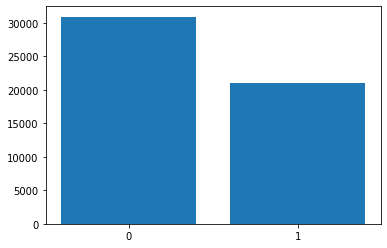

In [ ]:
plt.bar(["0","1"],[m_st-pos_st,pos_st])

<BarContainer object of 2 artists>

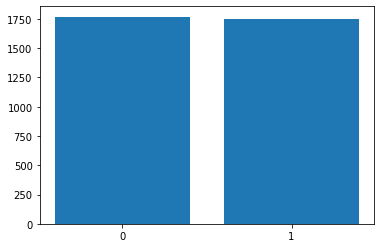

In [ ]:
plt.bar(["0","1"],[m_qu-pos_qu,pos_qu])

<BarContainer object of 2 artists>

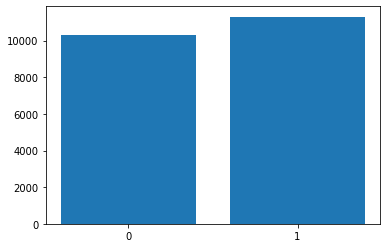

In [ ]:
plt.bar(["0","1"],[m_ex-pos_ex,pos_ex])

In [ ]:
vect = TfidfVectorizer()
shape = vect.fit_transform(datadev["text"]).shape
text = np.array([replaceURL(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])
print(np.where(vect.get_feature_names_out() == "url"))


156707
147863
(array([137926]),)


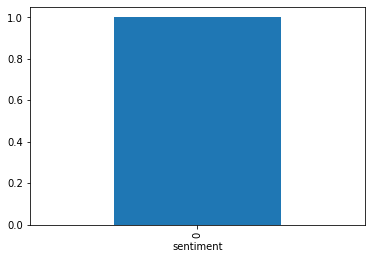

In [ ]:
mask = text[:,137659].nonzero()[0]
datadev.iloc[mask].groupby("sentiment").count()["ids"].plot.bar()

In [ ]:
text = np.array([replaceAtUser(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])
print(np.where(vect.get_feature_names_out() == "atuser"))

156707
88224
(array([11723]),)


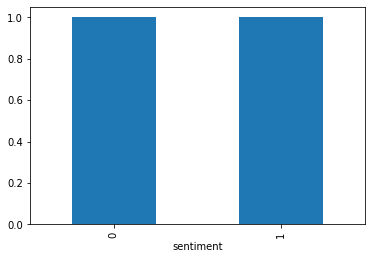

In [ ]:
mask = text[:,11691].nonzero()[0]
datadev.iloc[mask].groupby("sentiment").count()["ids"].plot.bar()

In [ ]:
text = np.array([removeHashtagInFrontOfWord(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])

156707
156719


In [ ]:
text = np.array([replaceMultiExclamationMark(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])
print(np.where(vect.get_feature_names_out() == "multiexclamation"))

156707
156708
(array([97225]),)


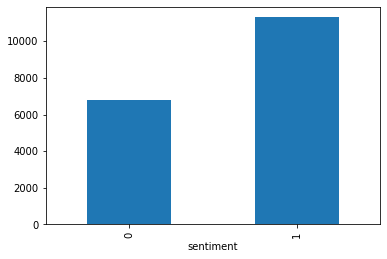

In [ ]:
mask = text[:,97225].nonzero()[0]
datadev.iloc[mask].groupby("sentiment").count()["ids"].plot.bar()

In [ ]:
text = np.array([replaceMultiQuestionMark(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])
print(np.where(vect.get_feature_names_out() == "multiquestion"))

156707
156708
(array([97237]),)


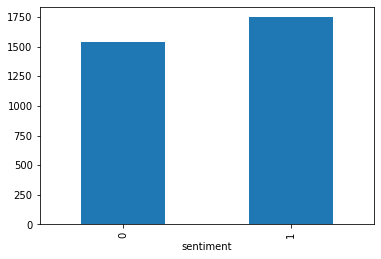

In [ ]:
mask = text[:,97237].nonzero()[0]
datadev.iloc[mask].groupby("sentiment").count()["ids"].plot.bar()

In [ ]:
text = np.array([replaceMultiStopMark(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])
print(np.where(vect.get_feature_names_out() == "multistop"))

156707
156708
(array([97237]),)


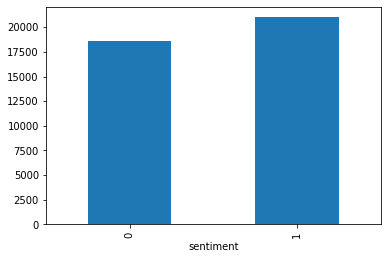

In [ ]:
mask = text[:,97237].nonzero()[0]
datadev.iloc[mask].groupby("sentiment").count()["ids"].plot.bar()

In [ ]:
text = np.array([replaceElongated(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])

156707
144949


In [ ]:
text = np.array([replaceContraction(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
print(shape[1])
text = vect.fit_transform(text)
print(text.shape[1])

156707
159279


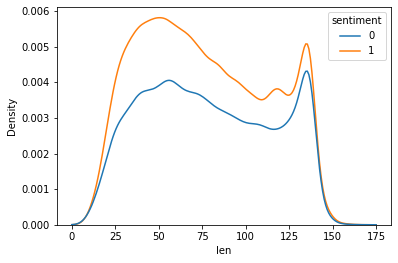

In [ ]:
import seaborn as sns
datadev["len"] = np.array([len(datadev["text"].iloc[i]) for i in range(0,len(datadev))])
sns.kdeplot(data=datadev, x="len", hue="sentiment", clip= (0.0, 175.0))


#Data preprocessing


In [ ]:
datadev = datadev.drop_duplicates(subset="text",keep=False)

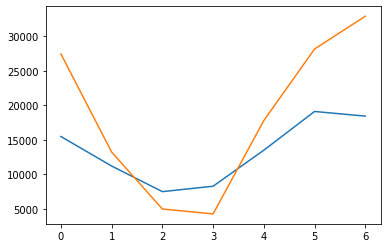

In [ ]:
datadev["week"] = datadev["date"].dt.weekday
plt.plot(datadev.loc[datadev["sentiment"] == 0].groupby("week").count()["ids"])
plt.plot(datadev.loc[datadev["sentiment"] == 1].groupby("week").count()["ids"])
plt.show()

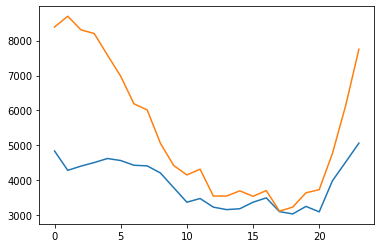

In [ ]:
datadev["hour"] = datadev["date"].dt.hour
plt.plot(datadev.loc[datadev["sentiment"] == 0].groupby("hour").count()["ids"])
plt.plot(datadev.loc[datadev["sentiment"] == 1].groupby("hour").count()["ids"])
plt.show()


In [ ]:
stats = datadev.groupby("user")["sentiment"].describe()[["mean","std"]]
stats = stats.fillna(0)
array = np.array([stats.loc[datadev["user"].iloc[i]] for i in range(0,len(datadev))])
datadev[["mean","std"]]= array

In [ ]:
X = datadev[["mean","std","hour","week","text"]]
X["text"] = preprocess(X["text"])
y = datadev["sentiment"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#Pipeline selection and tuning hyperparameters

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

tfidf = TfidfVectorizer(ngram_range = (1,2))
count = CountVectorizer(ngram_range = (1,2))

##Baseline with MultinomialNB

In [ ]:
clmn = ColumnTransformer([("count", count, "text")], remainder="passthrough")
model = MultinomialNB()

pipeline = Pipeline(steps = [("clmn",clmn), ("model",model)] )

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
f1_score(y_test, y_pred,average="macro")

0.7855361666354729

##Gridsearch for pipeline selection

In [ ]:
model = SGDClassifier()
clmn = ColumnTransformer([("tfidf", count, "text")], remainder="passthrough")
select = SelectFromModel(RidgeClassifier(),threshold="median")


pipeline = Pipeline(steps = [("clmn",clmn), ("select",select), ("model",model)] )

In [ ]:
params_grid = [
                {
                'clmn' : [ ColumnTransformer([("count", count, "text")], remainder="passthrough"), ColumnTransformer([("tfidf", tfidf, "text")], remainder="passthrough")],
                'select' : [SelectFromModel(SGDClassifier(),threshold="median"), SelectFromModel(RidgeClassifier(),threshold="median"), None],
                'model':[SGDClassifier()],
                #"model__loss" : ["hinge"], default
                #"model__penalty" : ["l2", "elasticnet"],
                #"model__tol" : [1e-3,1e-4],
                #"model__learning_rate" : ["adaptive","constant"],
                #"model__eta0" : [0.1,0.5,1]
                },
                {
                'clmn' : [ ColumnTransformer([("count", count, "text")], remainder="passthrough"),ColumnTransformer([("tfidf", tfidf, "text")], remainder="passthrough")],
                'select' : [SelectFromModel(SGDClassifier(),threshold="median"), SelectFromModel(RidgeClassifier(),threshold="median"), None],
                'model':[RidgeClassifier()],
                #"model__solver" : ["auto", "saga", "sparse_cg"],
                #"model__fit_intercept" : [True,False],
                #"model__tol" : [1e-3,1e-4],
                #"model__alpha" : [0.1,0.5,1]
                }
              ]

gridsearch = GridSearchCV(pipeline, params_grid, scoring='f1_macro', cv=5)
gridsearch.fit(X_train, y_train)


In [ ]:
#gridpipeline is the object of the previous grisearch
#we decided to share it because it needs a lot of time to run this gridsearch
#same thing was done for a second gridsearch for tuning hyperparameters
grid = joblib.load("gridpipeline.pkl")

In [ ]:
grid.cv_results_

{'mean_fit_time': array([ 19.57919326, 129.37812476,  15.3891748 ,  21.39107952,
         29.99692893,  17.02985492,  91.73352952, 159.08718534,
        124.66516948,  30.3707376 ,  35.52928329,  28.80589619]),
 'mean_score_time': array([1.47173352, 1.54768772, 1.41232605, 1.7270062 , 1.69629445,
        1.68238015, 1.51558285, 1.48651114, 1.47991381, 1.77686286,
        1.72231975, 1.67345567]),
 'mean_test_score': array([0.8302941 , 0.83786774, 0.82750322, 0.81034361, 0.82192834,
        0.7933593 , 0.81325847, 0.81062783, 0.81318494, 0.84373403,
        0.84298554, 0.8435968 ]),
 'param_clmn': masked_array(data=[ColumnTransformer(remainder='passthrough',
                   transformers=[('count', CountVectorizer(ngram_range=(1, 2)),
                                  'text')]),
                    ColumnTransformer(remainder='passthrough',
                   transformers=[('count', CountVectorizer(ngram_range=(1, 2)),
                                  'text')]),
                    C

In [ ]:
grid.best_estimator_

Pipeline(steps=[('clmn',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'text')])),
                ('select',
                 SelectFromModel(estimator=SGDClassifier(),
                                 threshold='median')),
                ('model', RidgeClassifier())])

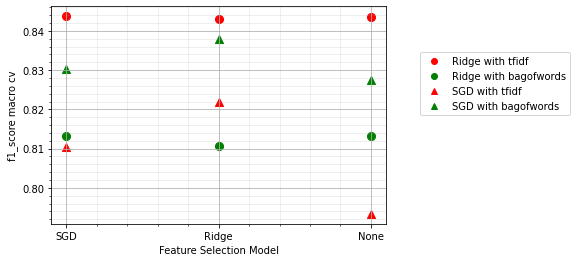

In [ ]:
#indici delle combinazioni riscontrabili da cv_results_
tfidf = [3,4,5,9,10,11]
count = [0,1,2,6,7,8]
sgd = [0,1,2,3,4,5]
ridge = [6,7,8,9,10,11]

num = grid.cv_results_['mean_test_score']

label = ["SGD", "Ridge", "None"]
for i,el in enumerate(num):
  if i in tfidf:
    col = "r"
  else:
    col = "g"
  
  if i in sgd: 
    mar = "^"
  else:
    mar = "o"
  j = i % 3
  lab = label[j]

  plt.scatter(lab,el,marker = mar, color = col, s=65)


legend_el = [Line2D([0], [0], marker='o', color='r', label='Ridge with tfidf',linestyle=''),
             Line2D([0], [0], marker='o', color='g', label='Ridge with bagofwords',linestyle=''),
             Line2D([0], [0], marker='^', color='r', label='SGD with tfidf',linestyle=''),
             Line2D([0], [0], marker='^', color='g', label='SGD with bagofwords',linestyle=''),
             ]
plt.legend(handles = legend_el,loc=(1.1,0.5))
plt.xlabel("Feature Selection Model")
plt.ylabel("f1_score macro cv")

plt.grid(b=True, which='major')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

fig1 = plt.gcf()
plt.show()
fig1.savefig('filename.svg')  

##Gridsearch for tuning hyperparameters

In [ ]:
params_grid = [
                {
                'clmn' : [ ColumnTransformer([("count", count, "text")], remainder="passthrough")],
                'select' : [SelectFromModel(RidgeClassifier(),threshold="median")],
                'model':[SGDClassifier()],
                "model__penalty" : ["l2", "elasticnet"],
                "model__tol" : [1e-3,1e-4],
                "model__learning_rate" : ["adaptive","constant"],
                "model__eta0" : [0.1,0.5,1]
                },
                {
                'clmn' : [ ColumnTransformer([("tfidf", tfidf, "text")], remainder="passthrough")],
                'select' : [SelectFromModel(SGDClassifier(),threshold="median")],
                'model':[RidgeClassifier()],
                "model__solver" : ["auto", "saga", "sparse_cg"],
                "model__fit_intercept" : [True,False],
                "model__tol" : [1e-3,1e-4],
                "model__alpha" : [0.1,0.5,1]
                }
              ]

gridsearch = GridSearchCV(pipeline, params_grid, scoring='f1_macro', cv=5)
gridsearch.fit(X_train, y_train)


In [ ]:
grid = joblib.load("gridmodel.pkl")

In [ ]:
grid.cv_results_

{'mean_fit_time': array([ 86.24456558,  78.63509059,  69.25543227,  67.64905438,
         83.39322214,  78.00885272,  81.40366759,  89.96070595,
         96.68629193,  83.15077534,  69.67281127,  68.4543056 ,
         60.34497604,  61.4625247 ,  66.14661045,  65.30884676,
         61.73165154,  77.42032847,  81.33217063, 102.96762428,
        101.72053351,  90.46450272,  76.699541  ,  75.78544178,
         41.24025145,  47.23946261,  12.95502777,  12.23438845,
         32.19222875,  35.81660295,  32.86894388,  36.51299424,
         67.53238769, 179.64562168,  40.67500057,  45.07555671,
         21.93214149,  26.66693869,  11.75980787,  11.63275919,
         19.65156608,  25.1239295 ,  19.77828121,  23.42207136,
         49.05065947, 145.52924218,  20.15264096,  25.32174225,
         18.64491653,  19.09139423,  11.53916636,  11.98476553,
         17.72484016,  20.27440138,  18.64084516,  19.43554153,
         38.853791  , 150.49777451,  20.07301316,  21.21801291]),
 'mean_score_time': a

In [ ]:
grid.best_params_

{'clmn': ColumnTransformer(remainder='passthrough',
                   transformers=[('tfidf', TfidfVectorizer(ngram_range=(1, 2)),
                                  'text')]),
 'model': RidgeClassifier(alpha=0.1, fit_intercept=False, solver='saga'),
 'model__alpha': 0.1,
 'model__fit_intercept': False,
 'model__solver': 'saga',
 'model__tol': 0.001,
 'select': SelectFromModel(estimator=SGDClassifier(), threshold='median')}

In [ ]:
grid.score(X_test,y_test)

0.8898010300264543

In [ ]:
model = grid.best_estimator_
#used for first evaluation

##Word cloud

In [ ]:
words = model["clmn"].transformers_[0][1].get_feature_names_out()
numbers = model["clmn"].get_feature_names_out()[len(words):]
columns = np.hstack((words,numbers))
subset = model["select"].get_feature_names_out(columns)
coef = np.abs(model["model"].coef_[0])

In [ ]:
dct = {subset[i]:coef[i] for i in range(0,len(subset))}

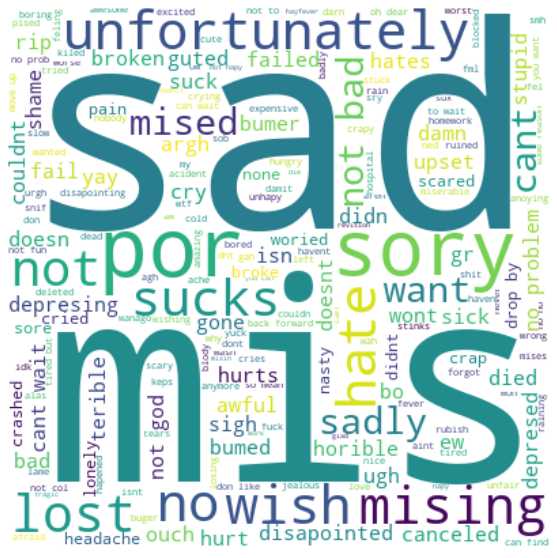

In [ ]:
wc = WordCloud(background_color='white', width = 400, height=400, margin=2)
wc.fit_words(dct)
fname = "cloud_test" 
plt.axis("off")
fig = plt.gcf() #get current figure
fig.set_size_inches(10,10)
plt.imshow(wc, interpolation="bilinear")
plt.savefig(fname + ".svg", dpi=900, format="svg")
plt.imshow(wc, interpolation="bilinear")

#First Evaluaation

sgd per feature reduction
e poi bilanciamento dataset
modello tra sgd e percepton e ridge


In [ ]:
X = datadev[["mean","std","hour","week","text"]]

In [ ]:
X["text"] = preprocess(X["text"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
datatest = pd.read_csv("DSL2122_january_dataset/evaluation.csv",parse_dates=["date"])

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [ ]:
array_eval = []
users = datadev["user"].unique()
for el in datatest["user"]:
  if el in users:
    array_eval.append(stats.loc[el])
  else:
    array_eval.append(np.array([0.5,0.5]))

array_eval = np.array(array_eval)

In [ ]:
datatest["week"] = datatest["date"].dt.weekday
datatest["hour"] = datatest["date"].dt.hour
datatest[["mean","std"]] = array_eval
X_eval = datatest[["mean","std","hour","week","text"]]

In [ ]:
y = datadev["sentiment"]
X_eval["text"] = preprocess(X_eval["text"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
model.fit(X,y)
y_pred = model.predict(X_eval)

submission = pd.read_csv("DSL2122_january_dataset/sample_submission.csv")
submission["Predicted"] = y_pred
submission.to_csv("result.csv",index=False)
